In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_regression import bimodal_data, plot_scatter
import matplotlib.pyplot as plt

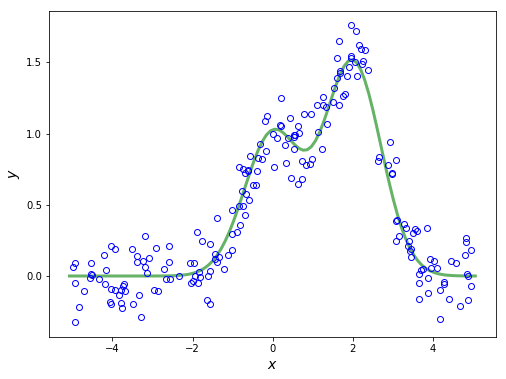

In [3]:
X_train, y_train, X_test, y_test, f_truth= bimodal_data(300)
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, f=f_truth)
plt.show()

## 装袋法

In [51]:
from pylib.utils.functions_for_regression import plot_fitted_line
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import BaggingRegressor
from copy import deepcopy

In [117]:
class BaggingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator=DecisionTreeRegressor(), n_estimators=10, 
                 max_samples=1.0):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        
    def __bootstrap(self, X, y, max_samples):
        sample_idx = np.random.choice(len(X), size=max_samples, replace=True)
        return X[sample_idx], y[sample_idx]
    
    def fit(self, X, y):
        if isinstance(self.max_samples, float):
            max_samples = int(self.max_samples * len(X))
        self.estimators = []
        self.loss_history = []
        y_pred = np.zeros(max_samples)
        for i in range(self.n_estimators):
            estimator = deepcopy(self.estimator)
            X_subset, y_subset = self.__bootstrap(X, y, max_samples)
            estimator.fit(X_subset, y_subset)
            y_pred += estimator.predict(X_subset)
            loss = mean_squared_error(y_subset, y_pred / self.n_estimators)
            self.loss_history.append(loss)
            self.estimators.append(estimator)
            
        return self
    
    def predict(self, X):
        y_pred = np.zeros(len(X))
        for estimator in self.estimators:
            y_pred += estimator.predict(X)
        y_pred = y_pred / self.n_estimators
        return y_pred

In [130]:
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5),
                           n_estimators=50, max_samples=0.8)
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5), max_samples=0.8,
                 n_estimators=50)

In [131]:
y_pred = bagging.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.013


In [132]:
y_pred = bagging.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.025


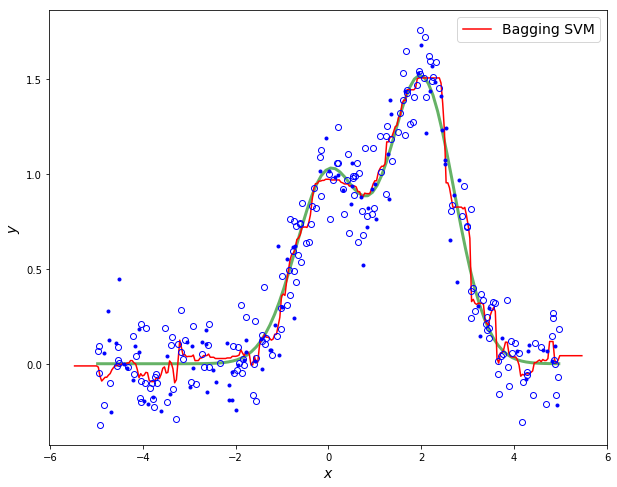

In [133]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
plot_fitted_line(bagging, "Bagging SVM")
plt.show()

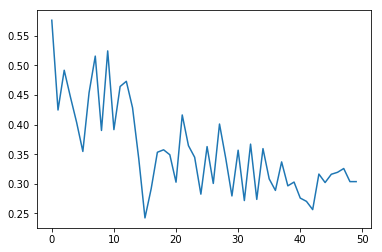

In [134]:
loss_history = bagging.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()